### setting up

In [2]:
# Python Modules
import os
from sys import path as syspath
syspath.append("../")

from collections import OrderedDict
from collections.abc import Mapping
import pickle as pkl
from copy import deepcopy
# Data Modules
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from sklearn.linear_model import LinearRegression

# Util Modules
from util.model_functions import getBrickDict
from util.td_model import ThermodynamicModel
from util.data_functions import lett2idx
from util.other_datasets_porting import *

# Bio Modules
from Bio import SeqIO

# Plotting Modules
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# NO DATA

In [3]:
# Definitions
def showdf(a_):
    from IPython.display import display
    display(a_.applymap("{0:0.1f}".format))

In [4]:
shinedalgarno = "aggag"

In [5]:
data = pd.read_excel("review_datasets/Data for Srdjan(2).xlsx", sheet_name=1)

FileNotFoundError: [Errno 2] No such file or directory: 'review_datasets/Data for Srdjan(2).xlsx'

In [4]:
data.columns = [c.strip() for c in data.columns] 

In [5]:
# (~np.isfinite(data["expression in M9"])).sum()

In [6]:
data.columns = [c.lower() for c in data.columns]
data['regulatory sequence'].apply(lambda xi: xi.find(shinedalgarno)).value_counts()

-1    29249
Name: regulatory sequence, dtype: int64

So, no Shine-Delgarno anywhere.

In [7]:
data['promoter length'] = data["regulatory sequence"].apply(len)
data["promoter length"].value_counts()

165    29249
Name: promoter length, dtype: int64

In [8]:
select = np.isfinite(data['expression in m9'])

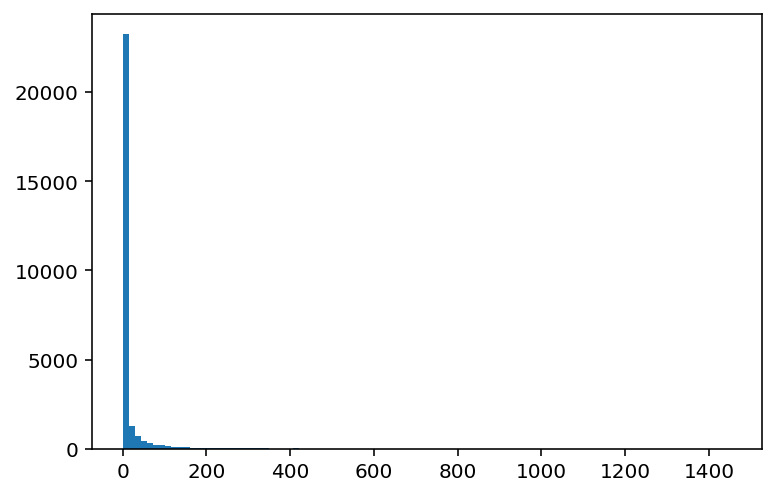

In [9]:
plt.hist(data[select]['expression in m9'],100)

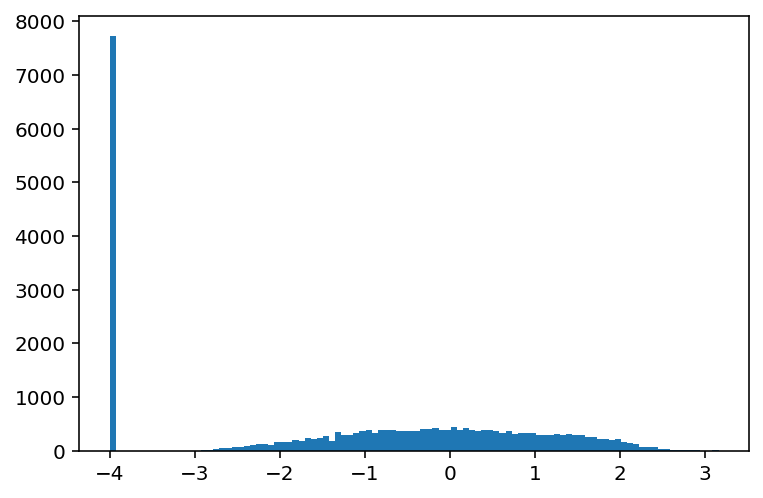

In [10]:
plt.hist(np.log10(.0001+data[select]['expression in m9']),100)

In [11]:
select.mean()

0.9269034838797907

In [26]:
lums = data['expression in m9'].values[select]
lums = np.maximum(lums[lums>0].min(), lums)
lums = np.log10(lums)

In [12]:
numseq = np.array([[lett2idx[l] for l in s.lower()] for s in data['regulatory sequence'][select]],dtype=np.int8)

In [8]:
with open("../models/fitted_on_Pr.Pl.36N/model_[5]_extended", "rb") as f:
    full_model = pkl.load(f)

C:\Users\drago\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
with open("../models/fitted_on_Pr.Pl.36N/model_[0]_stm.dmp", "rb") as f:
    simple_model = pkl.load(f)

C:\Users\drago\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
with open("../models/fitted_on_Pr/model_[4]_stm+flex+cumul+rbs+rc.dmp", "rb") as f:
    full_model_Pr = pkl.load(f)

C:\Users\drago\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
with open("../models/fitted_on_Pr/model_[0]_stm.dmp", "rb") as f:
    simple_model_Pr = pkl.load(f)

In [20]:
tdmodels = {
    "standard": dict2tdm(simple_model),
    "extended": dict2tdm(full_model),
    "standard[Pr]": dict2tdm(simple_model_Pr),
    "extended[Pr]": dict2tdm(full_model_Pr),
}

In [21]:
bricks = {k:tdmodels[k].sequences2bricks(numseq) for k in tdmodels}

In [22]:
{kk: {k: bricks[kk][k].shape for k in bricks[kk]} for kk in bricks}

{'standard': {'frw': (27111, 134, 1)},
 'extended': {'frw': (27111, 134, 5), 'rc': (27111, 134, 5)},
 'standard[Pr]': {'frw': (27111, 134, 1)},
 'extended[Pr]': {'frw': (27111, 134, 5), 'rc': (27111, 134, 5)}}

In [23]:
numseq.shape

(27111, 165)

## no weights

CPU times: user 9min 25s, sys: 6min 20s, total: 15min 45s
Wall time: 15min 45s


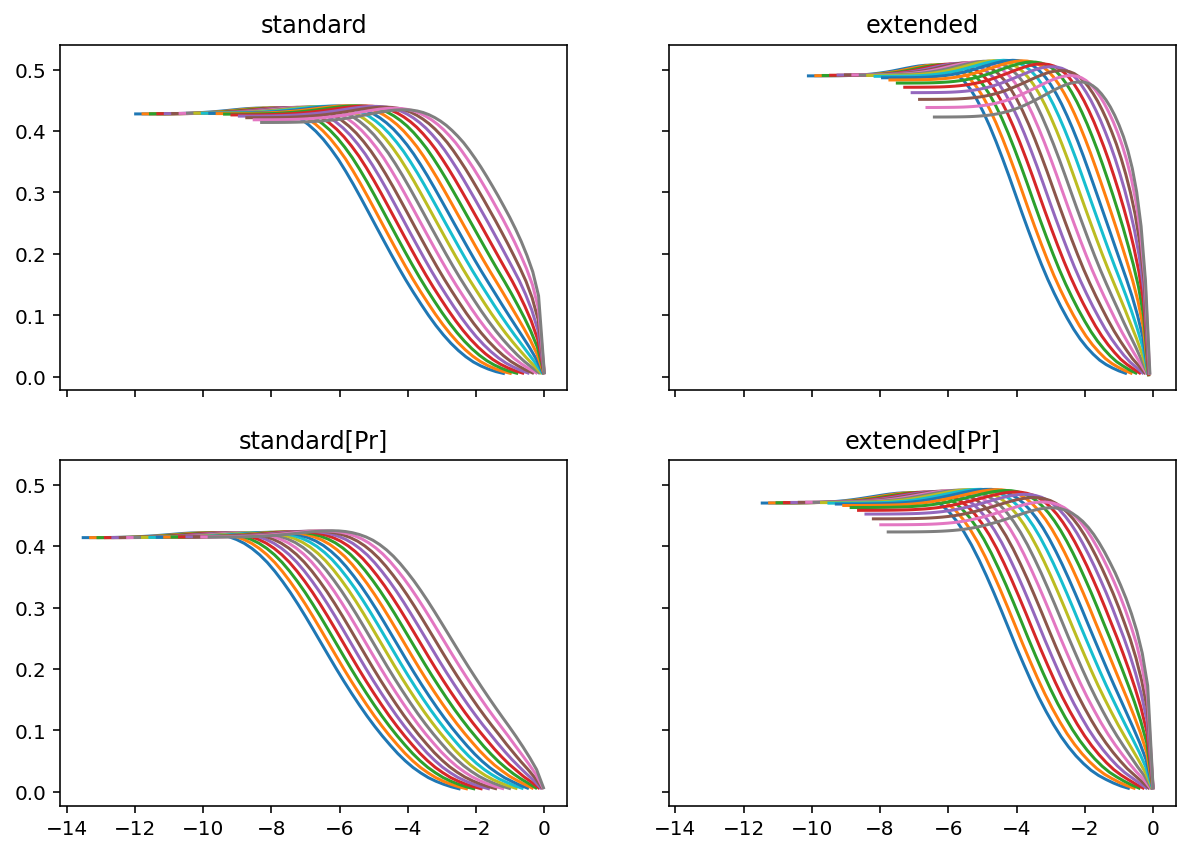

In [27]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-7,2,.5), loglums=lums, ax=ax)
    ax.set_title(k)

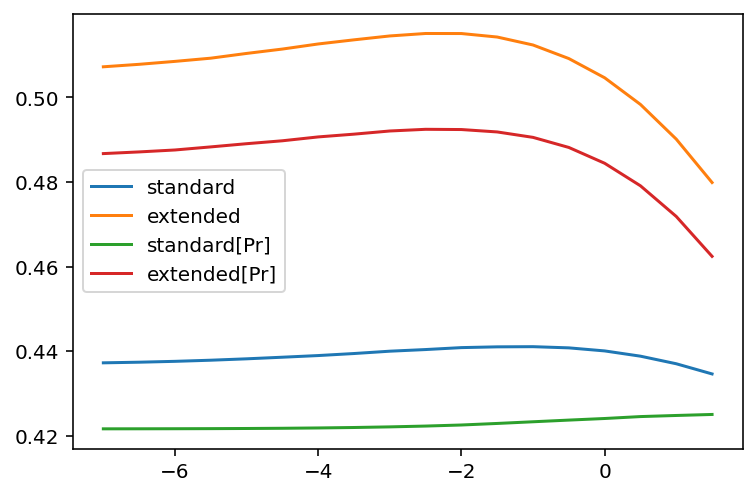

In [28]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

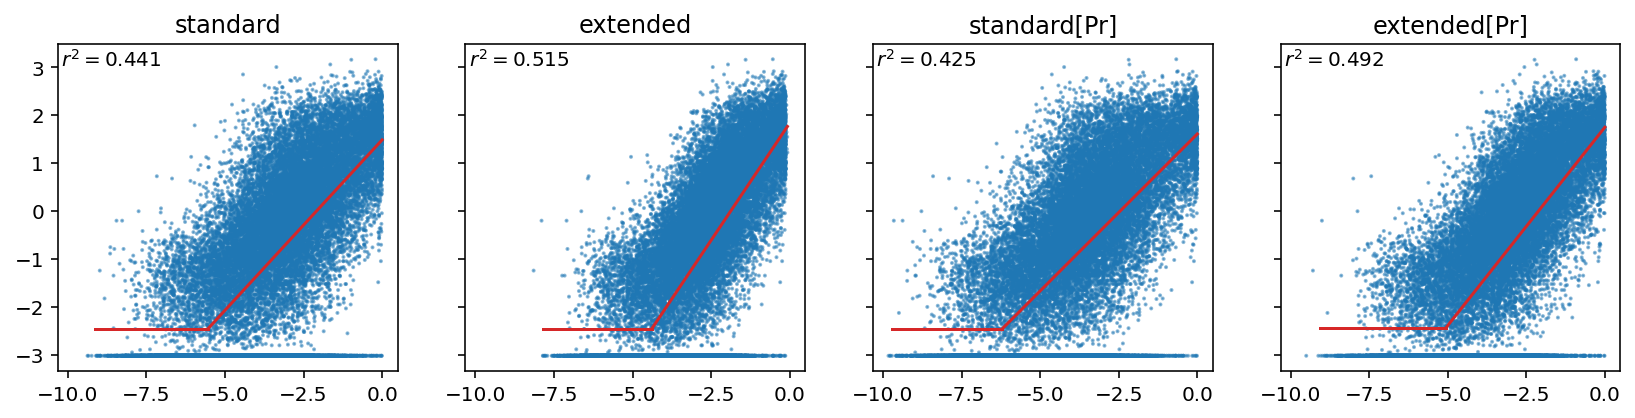

In [29]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax

    )
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

## neglect lum==0

In [31]:
wneg = np.ones(len(lums))
wneg[lums==lums.min()]=0

CPU times: user 9min 10s, sys: 6min 20s, total: 15min 31s
Wall time: 15min 31s


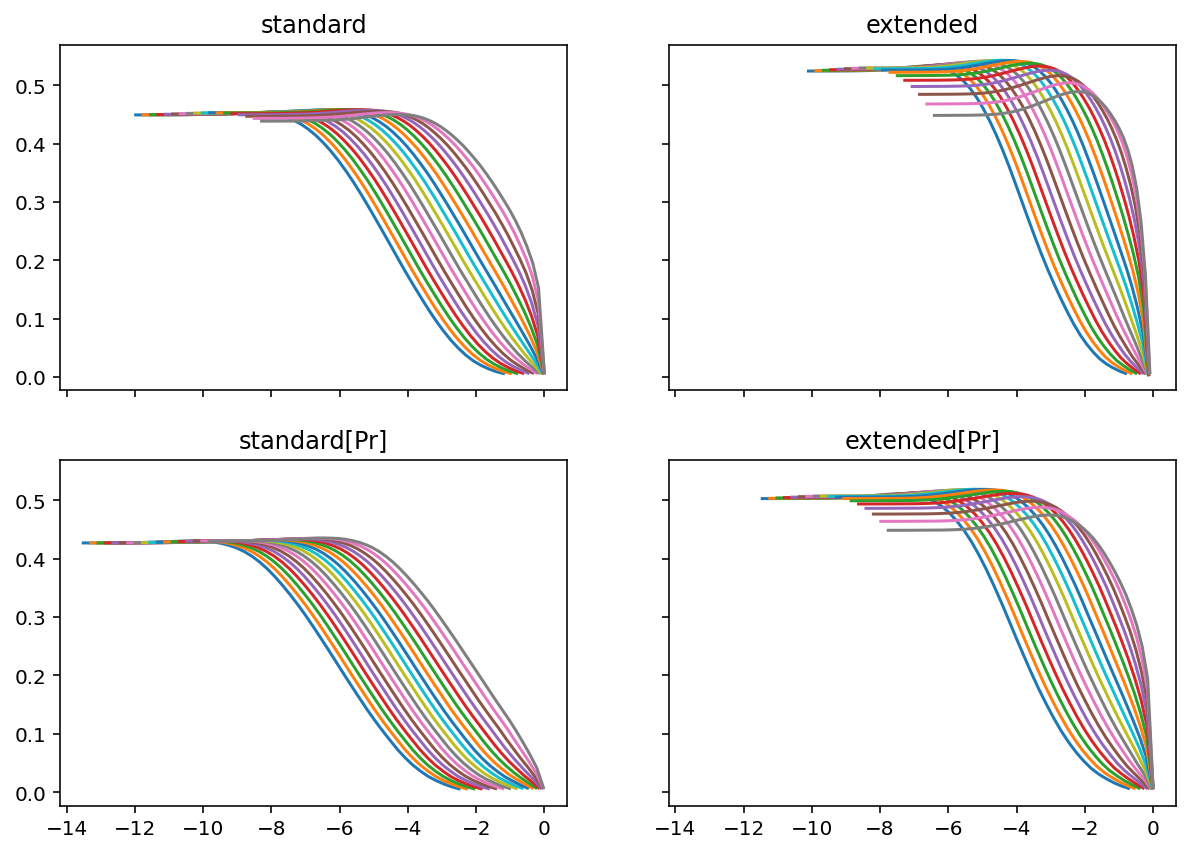

In [32]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-7,2,.5), loglums=lums, ax=ax, weights=wneg)
    ax.set_title(k)

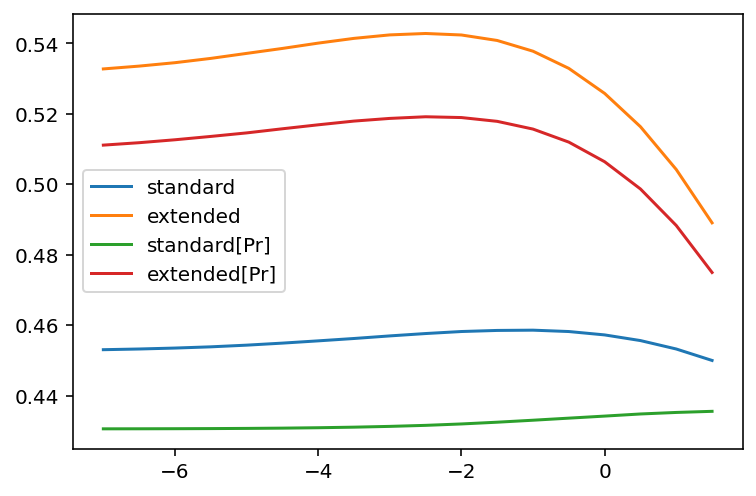

In [33]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

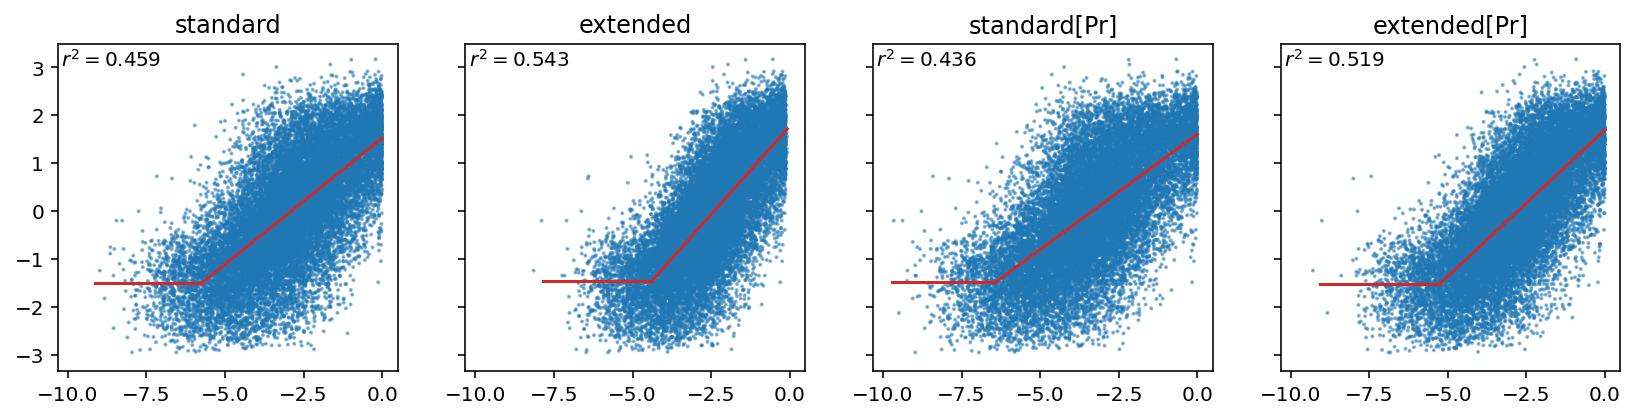

In [34]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax,
        weights=wneg
    )
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

In [12]:
.69**2

0.4760999999999999